### Deeper Stacked LSTM Model with Dropout and L2 Regularization

A deeper stacked LSTM model consists of multiple LSTM layers placed sequentially, allowing the network to learn complex temporal dependencies and hierarchical features by capturing short-term patterns in lower layers and longer-term ones in higher layers. To improve generalization and reduce overfitting, dropout is applied after each LSTM layer, randomly dropping neurons during training to prevent reliance on any single unit, which is important for deep models with many parameters. Additionally, L2 regularization adds a penalty on the squared magnitude of weights during training, encouraging smaller weights and controlling model complexity, making the combination of stacked LSTM, dropout, and L2 regularization a practical approach to building deep, robust, and expressive models for time-series forecasting tasks.

In [2]:
# --- Import additional layers and tools for experimentation ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [3]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("C:/Users/harit/OneDrive/Desktop/info project/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("C:/Users/harit/OneDrive/Desktop/prognosAI-Infosys-intern-project/milestone_2/week_3/Day_11/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [4]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [8]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [5]:
# Model with 2 stacked LSTM layers, dropout and L2 weight regularization
def build_stacked_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3, l2_reg=1e-4):
    model = Sequential([
        LSTM(lstm_units, activation='tanh', return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_reg),
             input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units, activation='tanh', return_sequences=False,
             kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_stacked_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_stacked.summary()


c:\Users\harit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,625 (260.25 KB)

 Trainable params: 66,625 (260.25 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [9]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 25414.5204
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 110s 52ms/step - loss: 19623.1953 - val_loss: 11604.6689 - learning_rate: 0.0010
Epoch 2/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10400.8959
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 120s 63ms/step - loss: 9098.0762 - val_loss: 5825.3857 - learning_rate: 0.0010
Epoch 3/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5289.9770
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 68s 36ms/step - loss: 4753.0913 - val_loss: 3810.9500 - learning_rate: 0.0010
Epoch 4/30
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3833.9135
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - loss: 3661.6467 - val_loss: 3073.1313 - learning_rate: 0.0010
Epoch 5/30
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3272.2971
Epoch 5: saving model to 

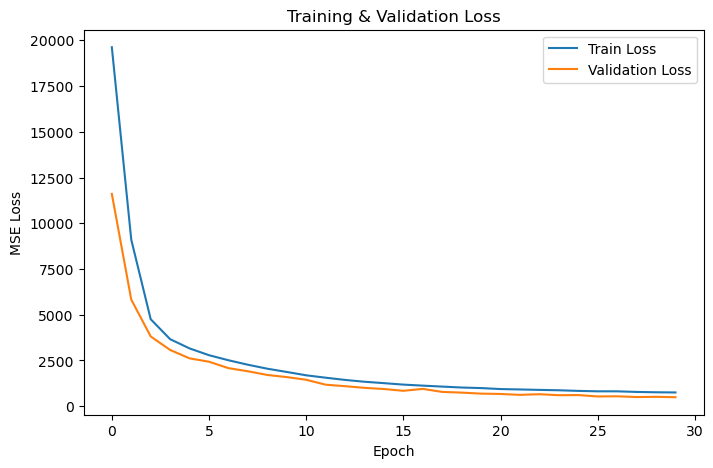

In [10]:
# Training and Validation Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


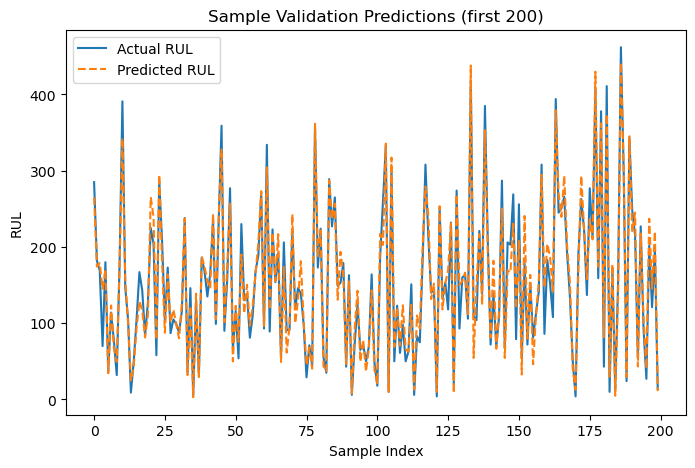

In [11]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()